In [6]:
from IPython.display import display,HTML
import warnings
warnings.filterwarnings(action='ignore')

#실습용 데이터 패키지
from sklearn.datasets import load_breast_cancer,load_boston
#데이터 전처리
import numpy as np
import pandas as pd 
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_boston
#기계학습 모델 및 평가
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from sklearn.metrics import accuracy_score,recall_score,precision_score,mean_squared_error
from sklearn.metrics import plot_confusion_matrix
from tqdm import tqdm
from sklearn.model_selection import KFold
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#시각화
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap
from datetime import datetime
from io import StringIO
matplotlib.rcParams['axes.unicode_minus'] = False
#한글 폰트 설정
plt.rc('font',family ='Malgun Gothic')




            index        총합        풍속        기압        기온        수온     유가  \
2013-01-31    107  1.817014  0.878058  1.366099 -1.580461 -1.289927  9.476   
2013-02-28    106  0.167115  0.883635  1.221884 -1.485442 -1.398883  9.531   
2013-03-31    105  0.207589  0.713755  0.218046 -0.938041 -1.254334  9.294   
2013-04-30    104  0.104223  0.813566 -0.446620 -0.646972 -1.056176  9.202   
2013-05-31    103  0.045963 -0.886747 -0.652127 -0.010883 -0.501255  9.451   
...           ...       ...       ...       ...       ...       ...    ...   
2021-08-31      4  0.786815 -0.495979 -1.234263  1.601184  1.795418  6.773   
2021-09-30      3  1.662624  0.777048 -0.514057  1.281736  1.448537  7.165   
2021-10-31      2  1.500648  0.354875  0.751628  0.685962  1.035938  8.148   
2021-11-30      1  1.891489  1.019060  0.582875 -0.061222  0.207945  7.915   
2021-12-31      0  3.132211  1.818463  1.311515 -0.860179 -0.403287  7.171   

             원데이터  
2013-01-31  3.371  
2013-02-28  3.371  
201

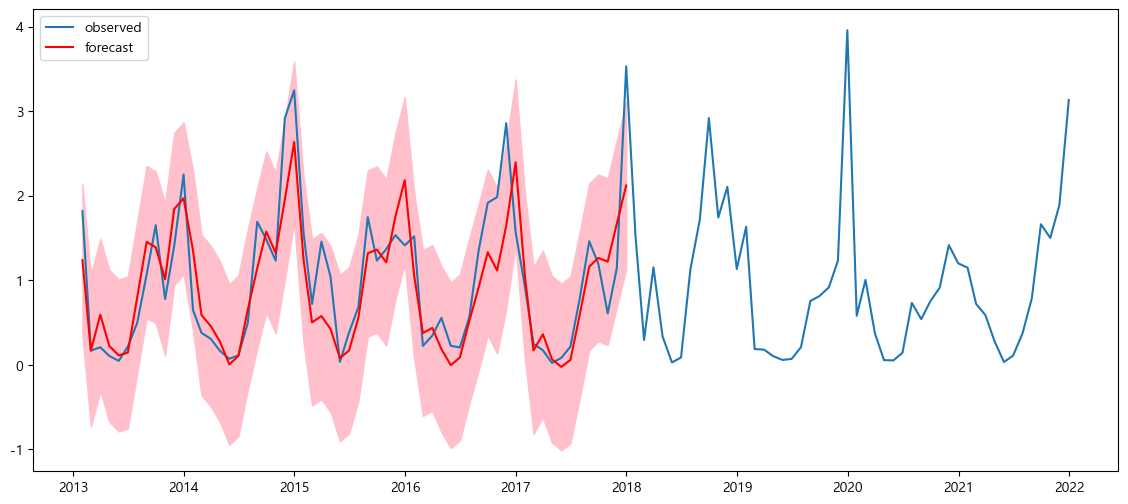

                                 SARIMAX Results                                  
Dep. Variable:                         총합   No. Observations:                  108
Model:             SARIMAX(1, 1, [1], 12)   Log Likelihood                 -74.760
Date:                    Thu, 23 Mar 2023   AIC                            167.521
Time:                            17:35:30   BIC                            190.600
Sample:                        01-31-2013   HQIC                           176.850
                             - 12-31-2021                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
유가            -0.0149      0.027     -0.548      0.584      -0.068       0.038
원데이터          -0.2539      0.306     -0.831      0.406      -0.853       0.345
수온             0.891

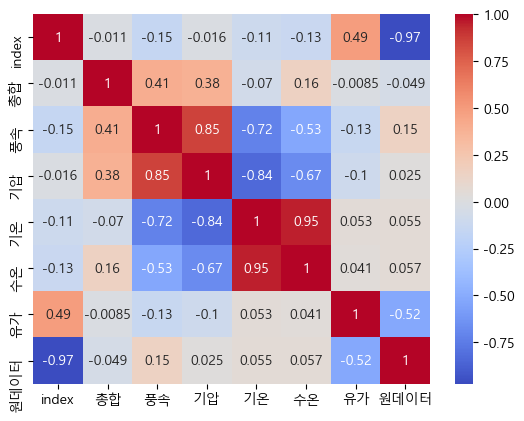

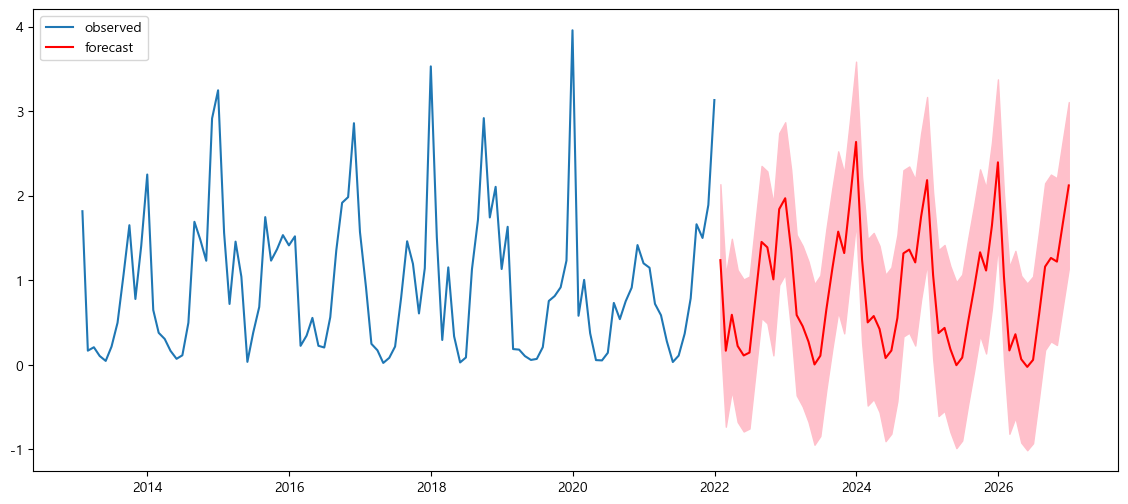

                                 SARIMAX Results                                  
Dep. Variable:                         총합   No. Observations:                  108
Model:             SARIMAX(1, 1, [1], 12)   Log Likelihood                 -74.760
Date:                    Thu, 23 Mar 2023   AIC                            167.521
Time:                            17:35:31   BIC                            190.600
Sample:                        01-31-2013   HQIC                           176.850
                             - 12-31-2021                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
유가            -0.0149      0.027     -0.548      0.584      -0.068       0.038
원데이터          -0.2539      0.306     -0.831      0.406      -0.853       0.345
수온             0.891

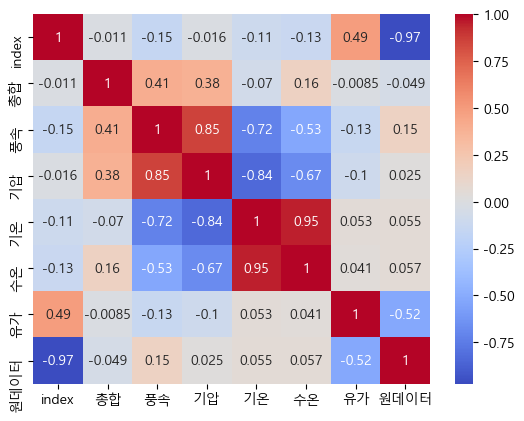

In [12]:
# fish1.csv 파일을 읽어옵니다.

data = pd.read_csv('data2.csv', parse_dates=True, encoding='ms949')
data = data.reset_index()  # 인덱스를 열로 변환
data = data.rename(columns={'시점': 'date'})  # 열 이름 변경
data['date'] = pd.to_datetime(data['date'], format="%Y.%m")  # 날짜 형식으로 변환
data = data.set_index('date')  # 다시 인덱스로 설정


# 인덱스를 PeriodIndex로 변환합니다.
data = data.iloc[::-1]
data.index = pd.date_range(start='2013-01', periods=len(data), freq='M')
# exog를 다시 정의합니다.
# X100ton
data['총합'] = data['총합']/10000

data['원데이터'] = data['원데이터']/1000000
data['수온'] = data['수온']
data['기온'] = data['기온']
data['기압'] = data['기압']
data['풍속'] = data['풍속']
data['유가'] = data['유가']/10
exog = data[['유가','원데이터','수온','기온','기압','풍속']]

print(data)
# 시계열 모델을 학습합니다.
model = SARIMAX(data['총합'], order=(0, 0, 0), seasonal_order=(1, 1, 1, 12), exog=exog)
results = model.fit(disp=False)

# 예측 기간을 설정합니다.
forecast_steps = 60

# 예측 결과와 신뢰 구간을 얻습니다.
forecast = results.get_forecast(steps=forecast_steps, exog=exog[-forecast_steps:])
forecast_conf_int = forecast.conf_int()

# 예측 결과의 인덱스를 원본 데이터와 동일한 시간 범위로 설정합니다.
from numpy import timedelta64

# 예측 결과의 인덱스를 원본 데이터와 동일한 시간 범위로 설정합니다.
# forecast_index = pd.period_range(start=data.index[-1] + timedelta64(1, 'M'), periods=forecast_steps, freq='M')

# forecast_index = pd.period_range(data.index[-1] + 1, periods=forecast_steps, freq='M')
forecast_index = pd.period_range(start='2013-01', periods=forecast_steps, freq='M')
forecast_index_timestamp = forecast_index.to_timestamp()  # PeriodIndex를 Timestamp로 변환
forecast.predicted_mean.index = forecast_index
forecast_conf_int.index = forecast_index

# 결과를 시각화합니다.
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(data.index, data['총합'], label='observed')
plt.plot(forecast_index, forecast.predicted_mean, label='forecast', color='r')
plt.fill_between(forecast_index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink')
plt.legend(loc='upper left')
plt.show()

print(results.summary())

# 예측 오차 계산
from sklearn.metrics import mean_squared_error
import numpy as np

y_true = data['총합'][-forecast_steps:]
y_pred = forecast.predicted_mean
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# 예측 오차 출력
print('RMSE:', rmse)
import seaborn as sns

corr = data.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.show()

forecast_index = pd.period_range(start='2022-01', periods=forecast_steps, freq='M')
forecast_index_timestamp = forecast_index.to_timestamp()  # PeriodIndex를 Timestamp로 변환
forecast.predicted_mean.index = forecast_index
forecast_conf_int.index = forecast_index

# 결과를 시각화합니다.
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(data.index, data['총합'], label='observed')
plt.plot(forecast_index, forecast.predicted_mean, label='forecast', color='r')
plt.fill_between(forecast_index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink')
plt.legend(loc='upper left')
plt.show()

print(results.summary())

# 예측 오차 계산
from sklearn.metrics import mean_squared_error
import numpy as np

y_true = data['총합'][-forecast_steps:]
y_pred = forecast.predicted_mean
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# 예측 오차 출력
print('RMSE:', rmse)
import seaborn as sns

corr = data.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.show()





In [11]:
import itertools

# 가능한 order와 seasonal_order 조합을 생성합니다.
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
s = 12
seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(itertools.product(p, d, q))]

# 모든 조합에 대해 모델을 훈련하고 AIC 값을 계산합니다.
best_aic = np.inf
best_order = None
best_seasonal_order = None
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(data['총합'], order=param, seasonal_order=param_seasonal, exog=exog)
            results = model.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
                best_seasonal_order = param_seasonal
        except:
            continue

# 최적값을 출력합니다.
print('Best AIC:', best_aic)
print('Best order:', best_order)
print('Best seasonal order:', best_seasonal_order)

Best AIC: 167.52096717720295
Best order: (0, 0, 0)
Best seasonal order: (1, 1, 1, 12)


            index        총합        풍속        기압        기온        수온     유가  \
2013-01-31    107  1.817014  0.878058  1.366099 -1.580461 -1.289927  9.476   
2013-02-28    106  0.167115  0.883635  1.221884 -1.485442 -1.398883  9.531   
2013-03-31    105  0.207589  0.713755  0.218046 -0.938041 -1.254334  9.294   
2013-04-30    104  0.104223  0.813566 -0.446620 -0.646972 -1.056176  9.202   
2013-05-31    103  0.045963 -0.886747 -0.652127 -0.010883 -0.501255  9.451   
...           ...       ...       ...       ...       ...       ...    ...   
2021-08-31      4  0.786815 -0.495979 -1.234263  1.601184  1.795418  6.773   
2021-09-30      3  1.662624  0.777048 -0.514057  1.281736  1.448537  7.165   
2021-10-31      2  1.500648  0.354875  0.751628  0.685962  1.035938  8.148   
2021-11-30      1  1.891489  1.019060  0.582875 -0.061222  0.207945  7.915   
2021-12-31      0  3.132211  1.818463  1.311515 -0.860179 -0.403287  7.171   

             원데이터  
2013-01-31  3.371  
2013-02-28  3.371  
201

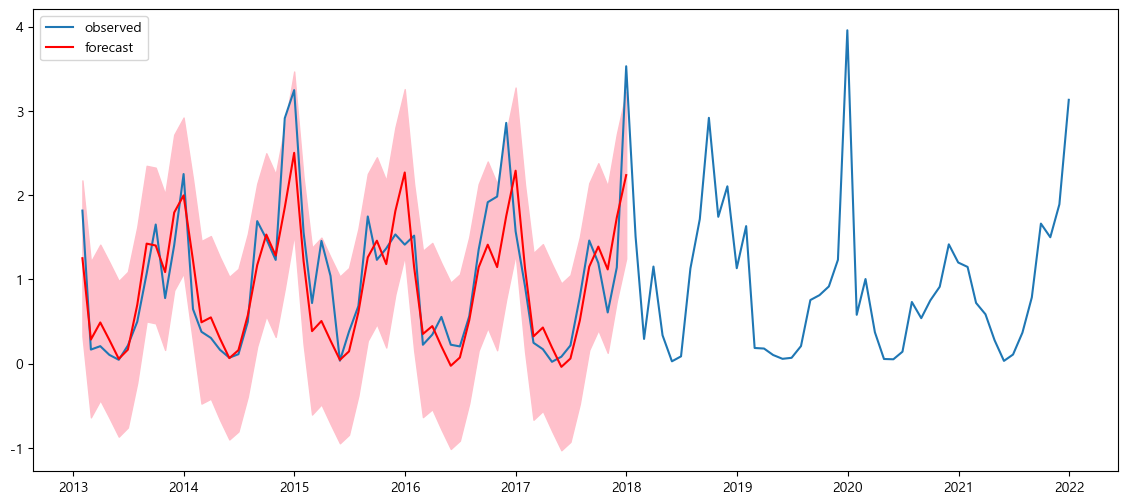

                                 SARIMAX Results                                  
Dep. Variable:                         총합   No. Observations:                  108
Model:             SARIMAX(1, 1, [1], 12)   Log Likelihood                 -76.878
Date:                    Thu, 23 Mar 2023   AIC                            161.756
Time:                            17:37:44   BIC                            172.013
Sample:                        01-31-2013   HQIC                           165.902
                             - 12-31-2021                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
원데이터          -0.2759      0.155     -1.779      0.075      -0.580       0.028
ar.S.L12      -0.4288      0.088     -4.889      0.000      -0.601      -0.257
ma.S.L12      -0.974

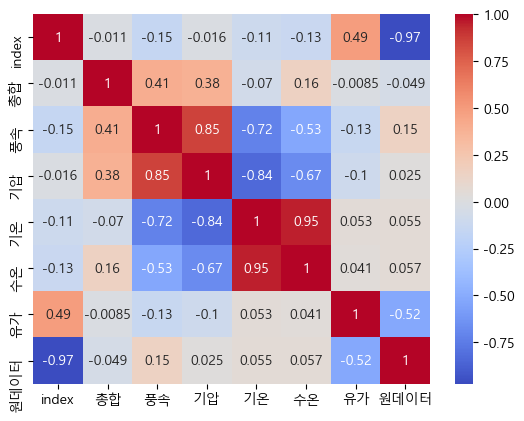

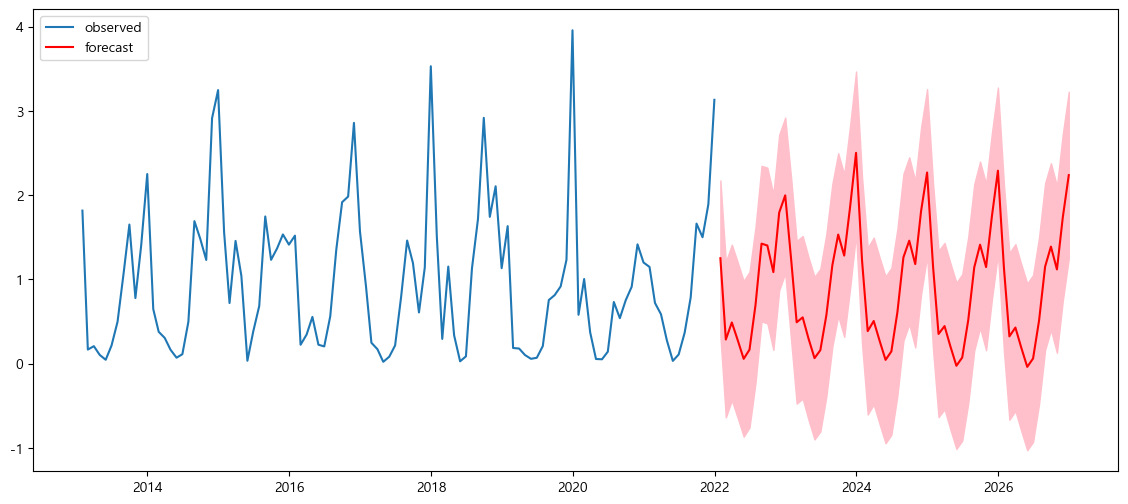

                                 SARIMAX Results                                  
Dep. Variable:                         총합   No. Observations:                  108
Model:             SARIMAX(1, 1, [1], 12)   Log Likelihood                 -76.878
Date:                    Thu, 23 Mar 2023   AIC                            161.756
Time:                            17:37:45   BIC                            172.013
Sample:                        01-31-2013   HQIC                           165.902
                             - 12-31-2021                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
원데이터          -0.2759      0.155     -1.779      0.075      -0.580       0.028
ar.S.L12      -0.4288      0.088     -4.889      0.000      -0.601      -0.257
ma.S.L12      -0.974

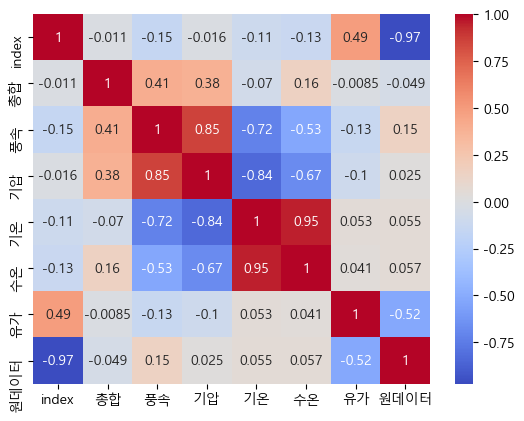

In [13]:
# fish1.csv 파일을 읽어옵니다.

data = pd.read_csv('data2.csv', parse_dates=True, encoding='ms949')
data = data.reset_index()  # 인덱스를 열로 변환
data = data.rename(columns={'시점': 'date'})  # 열 이름 변경
data['date'] = pd.to_datetime(data['date'], format="%Y.%m")  # 날짜 형식으로 변환
data = data.set_index('date')  # 다시 인덱스로 설정


# 인덱스를 PeriodIndex로 변환합니다.
data = data.iloc[::-1]
data.index = pd.date_range(start='2013-01', periods=len(data), freq='M')
# exog를 다시 정의합니다.
# X100ton
data['총합'] = data['총합']/10000

data['원데이터'] = data['원데이터']/1000000
data['수온'] = data['수온']
data['기온'] = data['기온']
data['기압'] = data['기압']
data['풍속'] = data['풍속']
data['유가'] = data['유가']/10
exog = data[['원데이터','수온','기온','기압','풍속']]

print(data)
# 시계열 모델을 학습합니다.
model = SARIMAX(data['총합'], order=(0, 0, 0), seasonal_order=(1, 1, 1, 12), exog=exog)
results = model.fit(disp=False)

# 예측 기간을 설정합니다.
forecast_steps = 60

# 예측 결과와 신뢰 구간을 얻습니다.
forecast = results.get_forecast(steps=forecast_steps, exog=exog[-forecast_steps:])
forecast_conf_int = forecast.conf_int()

# 예측 결과의 인덱스를 원본 데이터와 동일한 시간 범위로 설정합니다.
from numpy import timedelta64

# 예측 결과의 인덱스를 원본 데이터와 동일한 시간 범위로 설정합니다.
# forecast_index = pd.period_range(start=data.index[-1] + timedelta64(1, 'M'), periods=forecast_steps, freq='M')

# forecast_index = pd.period_range(data.index[-1] + 1, periods=forecast_steps, freq='M')
forecast_index = pd.period_range(start='2013-01', periods=forecast_steps, freq='M')
forecast_index_timestamp = forecast_index.to_timestamp()  # PeriodIndex를 Timestamp로 변환
forecast.predicted_mean.index = forecast_index
forecast_conf_int.index = forecast_index

# 결과를 시각화합니다.
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(data.index, data['총합'], label='observed')
plt.plot(forecast_index, forecast.predicted_mean, label='forecast', color='r')
plt.fill_between(forecast_index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink')
plt.legend(loc='upper left')
plt.show()

print(results.summary())

# 예측 오차 계산
from sklearn.metrics import mean_squared_error
import numpy as np

y_true = data['총합'][-forecast_steps:]
y_pred = forecast.predicted_mean
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# 예측 오차 출력
print('RMSE:', rmse)
import seaborn as sns

corr = data.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.show()

forecast_index = pd.period_range(start='2022-01', periods=forecast_steps, freq='M')
forecast_index_timestamp = forecast_index.to_timestamp()  # PeriodIndex를 Timestamp로 변환
forecast.predicted_mean.index = forecast_index
forecast_conf_int.index = forecast_index

# 결과를 시각화합니다.
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(data.index, data['총합'], label='observed')
plt.plot(forecast_index, forecast.predicted_mean, label='forecast', color='r')
plt.fill_between(forecast_index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink')
plt.legend(loc='upper left')
plt.show()

print(results.summary())

# 예측 오차 계산
from sklearn.metrics import mean_squared_error
import numpy as np

y_true = data['총합'][-forecast_steps:]
y_pred = forecast.predicted_mean
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# 예측 오차 출력
print('RMSE:', rmse)
import seaborn as sns

corr = data.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.show()





In [ ]:
# fish1.csv 파일을 읽어옵니다.

data = pd.read_csv('data2.csv', parse_dates=True, encoding='ms949')
data = data.reset_index()  # 인덱스를 열로 변환
data = data.rename(columns={'시점': 'date'})  # 열 이름 변경
data['date'] = pd.to_datetime(data['date'], format="%Y.%m")  # 날짜 형식으로 변환
data = data.set_index('date')  # 다시 인덱스로 설정


# 인덱스를 PeriodIndex로 변환합니다.
data = data.iloc[::-1]
data.index = pd.date_range(start='2013-01', periods=len(data), freq='M')
# exog를 다시 정의합니다.
# X100ton
data['총합'] = data['총합']/10000

data['원데이터'] = data['원데이터']/1000000
data['수온'] = data['수온']
data['기온'] = data['기온']
data['기압'] = data['기압']
data['풍속'] = data['풍속']
data['유가'] = data['유가']/10
exog = data[['원데이터','수온','기온','기압','풍속']]

print(data)
# 시계열 모델을 학습합니다.
model = SARIMAX(data['총합'], order=(0, 0, 0), seasonal_order=(1, 1, 1, 12), exog=exog)
results = model.fit(disp=False)

# 예측 기간을 설정합니다.
forecast_steps = 60

# 예측 결과와 신뢰 구간을 얻습니다.
forecast = results.get_forecast(steps=forecast_steps, exog=exog[-forecast_steps:])
forecast_conf_int = forecast.conf_int()

# 예측 결과의 인덱스를 원본 데이터와 동일한 시간 범위로 설정합니다.
from numpy import timedelta64

# 예측 결과의 인덱스를 원본 데이터와 동일한 시간 범위로 설정합니다.
# forecast_index = pd.period_range(start=data.index[-1] + timedelta64(1, 'M'), periods=forecast_steps, freq='M')

# forecast_index = pd.period_range(data.index[-1] + 1, periods=forecast_steps, freq='M')
forecast_index = pd.period_range(start='2013-01', periods=forecast_steps, freq='M')
forecast_index_timestamp = forecast_index.to_timestamp()  # PeriodIndex를 Timestamp로 변환
forecast.predicted_mean.index = forecast_index
forecast_conf_int.index = forecast_index

# 결과를 시각화합니다.
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(data.index, data['총합'], label='observed')
plt.plot(forecast_index, forecast.predicted_mean, label='forecast', color='r')
plt.fill_between(forecast_index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink')
plt.legend(loc='upper left')
plt.show()

print(results.summary())

# 예측 오차 계산
from sklearn.metrics import mean_squared_error
import numpy as np

y_true = data['총합'][-forecast_steps:]
y_pred = forecast.predicted_mean
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# 예측 오차 출력
print('RMSE:', rmse)
import seaborn as sns

corr = data.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.show()

forecast_index = pd.period_range(start='2022-01', periods=forecast_steps, freq='M')
forecast_index_timestamp = forecast_index.to_timestamp()  # PeriodIndex를 Timestamp로 변환
forecast.predicted_mean.index = forecast_index
forecast_conf_int.index = forecast_index

# 결과를 시각화합니다.
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(data.index, data['총합'], label='observed')
plt.plot(forecast_index, forecast.predicted_mean, label='forecast', color='r')
plt.fill_between(forecast_index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink')
plt.legend(loc='upper left')
plt.show()

print(results.summary())

# 예측 오차 계산
from sklearn.metrics import mean_squared_error
import numpy as np

y_true = data['총합'][-forecast_steps:]
y_pred = forecast.predicted_mean
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# 예측 오차 출력
print('RMSE:', rmse)
import seaborn as sns

corr = data.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.show()



